# Performance plot for ACAT 24 proceedings

* **`gnn_tracking` version**: Check out `acat24` branch


In [2]:
from matplotlib import pyplot as plt

import pandas as pd

%load_ext autoreload
%autoreload 2

from pytorch_lightning import Trainer
import torch
from pathlib import Path


import pickle

from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScannerFixed
from gnn_tracking.training.tc import TCModule
from pytorch_lightning.utilities.model_summary import ModelSummary
from gnn_tracking.analysis.plotutils import Plot

import scienceplots

plt.style.use(["science", "notebook"])
from ocpaper231.data import model_exchange_path
from gnn_tracking.utils.nomenclature import variable_manager as vm

from ocpaper231.data import get_dm

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# settings
full_detector = True

In [3]:
_v = 10 if full_detector else 8
dm = get_dm(n_val=20, v=_v)

[06:57:39] INFO: DataLoader will load 900 graphs (out of 900 available).
[06:57:39] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v10/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v10/part_1/data21999_s0.pt
[06:57:39] INFO: DataLoader will load 20 graphs (out of 1000 available).
[06:57:39] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v10/part_9/data29005_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v10/part_9/data29024_s0.pt


In [4]:
if full_detector:
    chkpt_home = Path(
        "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/full_detector/lightning_logs/"
    )
    assert chkpt_home.exists()
    chkpt_path = (
        chkpt_home
        / "annoying-malkoha-from-neptune/checkpoints/persist/epoch=196-step=25200.ckpt"
    )
    assert chkpt_path.exists()
    namestub = "annoying-malkoha-from-neptune-196"
else:
    chkpt_home = Path(
        "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/pixel/lightning_logs/"
    )
    assert chkpt_home.exists()
    chkpt_path = (
        chkpt_home / "diligent-myrtle-curassow/checkpoints/epoch=299-step=270000.ckpt"
    )
    assert chkpt_path.exists()
    namestub = "diligent-myrtle-curassow"
namestub

'annoying-malkoha-from-neptune-196'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
lmodel = TCModule.load_from_checkpoint(chkpt_path, map_location=device)

[06:57:43] DEBUG: Getting class GraphTCNForMLGCPipeline from module gnn_tracking.models.track_condensation_networks
[06:57:43] DEBUG: Getting class MLGraphConstruction from module gnn_tracking.models.graph_construction
[06:57:43] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[06:57:43] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses.metric_learning
[06:57:43] DEBUG: Getting class DBSCANHyperParamScanner from module gnn_tracking.postprocessing.dbscanscanner


In [7]:
ModelSummary(lmodel)

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | GraphTCNForMLGCPipeline             | 1.6 M 
1 | preproc  | MLGraphConstruction                 | 1.1 M 
2 | loss_fct | GraphConstructionHingeEmbeddingLoss | 0     
-----------------------------------------------------------------
1.6 M     Trainable params
1.1 M     Non-trainable params
2.6 M     Total params
10.594    Total estimated model params size (MB)

In [41]:
# lmodel

# VS EPS

In [42]:
import numpy as np

eps = np.linspace(0.01, 1, 20)
ks = np.arange(1, 5)
trials = []
for e in eps:
    for k in ks:
        trials.append({"eps": e, "min_samples": k})

lmodel.cluster_scanner = DBSCANHyperParamScannerFixed(
    trials=trials,
)

In [43]:
ModelSummary(lmodel)

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | GraphTCNForMLGCPipeline             | 1.9 M 
1 | preproc  | MLGraphConstruction                 | 333 K 
2 | loss_fct | GraphConstructionHingeEmbeddingLoss | 0     
-----------------------------------------------------------------
1.9 M     Trainable params
333 K     Non-trainable params
2.2 M     Total params
8.950     Total estimated model params size (MB)

In [44]:
trainer = Trainer(accelerator=device)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
[04:43:44] INFO: DataLoader will load 20 graphs (out of 1000 available).
[04:43:44] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29005_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29024_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation DataLoader 0:   0%|                                                      | 0/20 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|█████████████████████████████████████████████| 20/20 [05:30<00:00,  0.06it/s]

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Validation DataLoader 0: 100%|█████████████████████████████████████████████| 20/20 [05:30<00:00,  0.06it/s]


In [46]:
with Path(f"~/paperresults/{namestub}-vs_eps.pkl").expanduser().open("wb") as f:
    pickle.dump(lmodel.cluster_scanner, f)

In [8]:
with Path(f"~/paperresults/{namestub}-vs_eps.pkl").expanduser().open("rb") as f:
    lmodel.cluster_scanner = pickle.load(f)

0.9803681646923026 0.6352631578947369


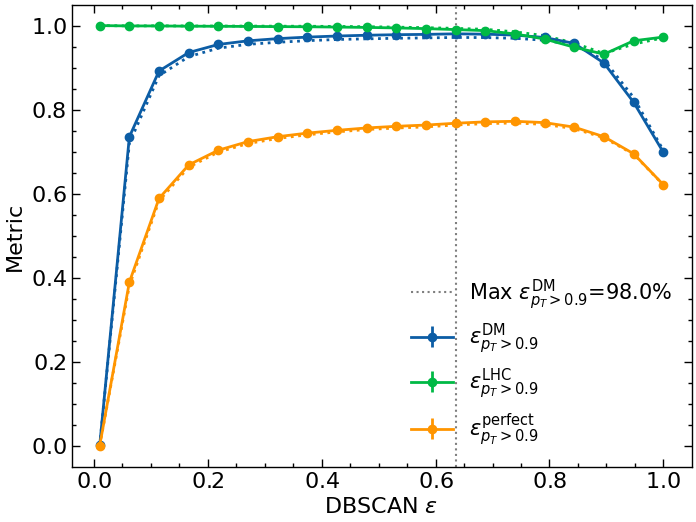

In [10]:
from gnn_tracking.analysis.efficiencies import TracksVsDBSCANPlot


tvdp = TracksVsDBSCANPlot(
    mean_df=lmodel.cluster_scanner.get_results().df_mean,
    # model=model,
    # watermark="outdated",
)
max_dm = tvdp.df["double_majority_pt0.9"].max()
max_dm_idx = tvdp.df["double_majority_pt0.9"].argmax()
max_dm_eps = tvdp.df.loc[max_dm_idx]["eps"]
print(max_dm, max_dm_eps)
secondary_k = 4
tvdp.plot_var("double_majority_pt0.9", secondary_k=secondary_k)
tvdp.plot_var("lhc_pt0.9", secondary_k=secondary_k)
tvdp.plot_var("perfect_pt0.9", secondary_k=secondary_k)
dm_label = vm["double_majority_pt0.9"].latex
tvdp.ax.axvline(
    max_dm_eps,
    color="k",
    ls=":",
    lw=1.5,
    alpha=0.5,
    label=rf"Max {dm_label}={100*max_dm:.1f}%",
)
tvdp.ax.legend(fontsize=15)
tvdp.save(Path.home() / f"paperresults/{namestub}-vs_eps.pdf")

In [11]:
tvdp.df.loc[max_dm_idx][
    [
        "fake_double_majority_pt0.9",
        "double_majority_pt0.9",
        "perfect_pt0.9",
        "lhc_pt0.9",
    ]
]

fake_double_majority_pt0.9    0.011907
double_majority_pt0.9         0.980368
perfect_pt0.9                 0.767504
lhc_pt0.9                     0.990487
Name: 48, dtype: float64

# vs pt and eta

In [50]:
h_dfs = []
c_dfs = []

In [51]:
from gnn_tracking.postprocessing.dbscanscanner import DBSCANPerformanceDetails

lmodel.cluster_scanner = DBSCANPerformanceDetails(eps=max_dm_eps, min_samples=1)

In [52]:
trainer = Trainer(accelerator="gpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [53]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
[04:50:08] INFO: DataLoader will load 20 graphs (out of 1000 available).
[04:50:08] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29005_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29024_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation DataLoader 0:   0%|                                                      | 0/20 [00:00<?, ?it/s]

Validation DataLoader 0: 100%|█████████████████████████████████████████████| 20/20 [02:08<00:00,  0.16it/s]


In [54]:
import itertools

In [55]:
with Path(f"~/paperresults/{namestub}-details.pkl").expanduser().open("wb") as f:
    pickle.dump(lmodel.cluster_scanner, f)

In [12]:
with Path(f"~/paperresults/{namestub}-details.pkl").expanduser().open("rb") as f:
    detail_scanner = pickle.load(f)

In [13]:
h_dfs, c_dfs = detail_scanner.get_results()

In [14]:
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_vs_pt,
    tracking_metrics_vs_eta,
)
import numpy as np


pts = np.array(np.arange(0, 3, 0.3).tolist() + [5.0])
vs_pt = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)
etas = np.array(np.linspace(-4, 4, 20).tolist() + [4.0])
vs_eta = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)
print(len(pts), len(vs_pt), len(etas), len(vs_eta))

11 10 21 20


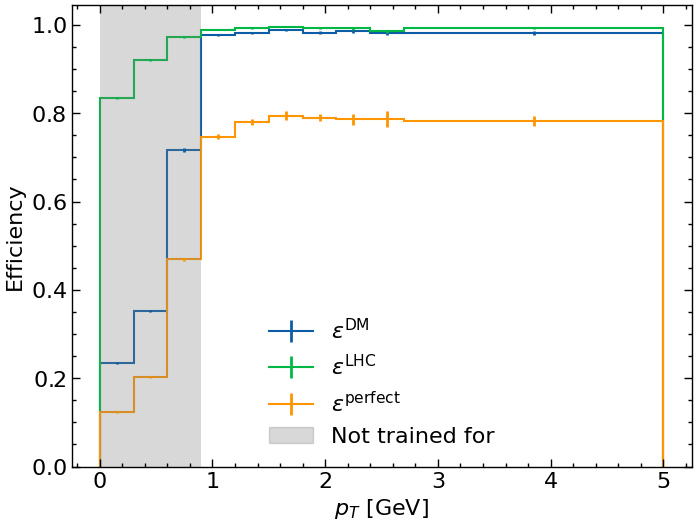

In [15]:
from gnn_tracking.analysis.efficiencies import PerformancePlot


p = PerformancePlot(df=vs_pt, xs=pts)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.add_blocked(0, 0.9)
p.add_legend()
p.save(Path.home() / f"paperresults/{namestub}-vs_pt.pdf")

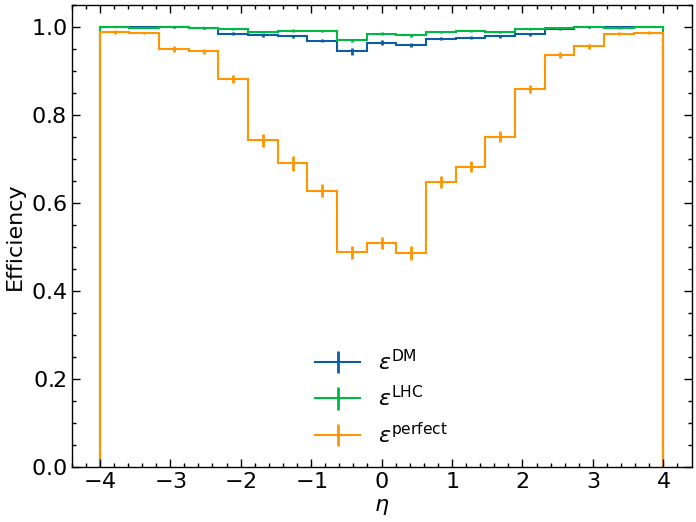

In [16]:
p = PerformancePlot(df=vs_eta, xs=etas, x_label=vm["eta"].latex)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.ax.legend()
p.add_legend()
p.save(Path.home() / f"paperresults/{namestub}-vs_eta.pdf")

/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/analysis/efficiencies.py:132: UserWarning: The label '_ignore' of (<matplotlib.patches.StepPatch object at 0x1489be446f80>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


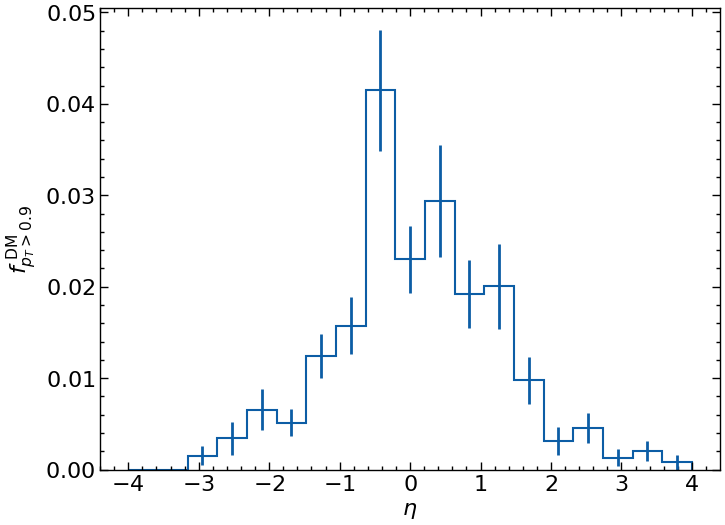

In [17]:
p = PerformancePlot(
    df=vs_eta,
    df_ul=None,
    xs=etas,
    x_label=vm["eta"].latex,
    y_label=r"$f^{\,\,\mathrm{DM}}_{p_T>0.9}$",
)
p.plot_var("fake_double_majority", "C0", label="_ignore")
p.add_legend()
p.save(Path.home() / f"paperresults/{namestub}-fake_vs_eta.pdf")

/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/analysis/efficiencies.py:132: UserWarning: The label '_' of (<matplotlib.patches.StepPatch object at 0x1489be391000>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


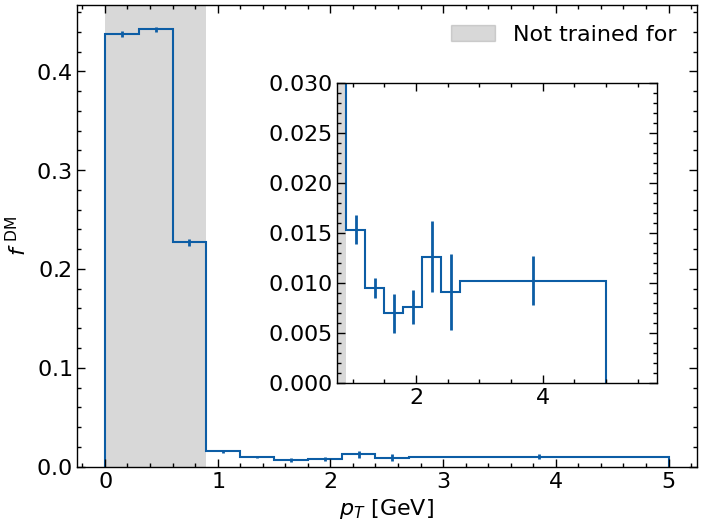

In [18]:
p = PerformancePlot(
    df=vs_pt,
    df_ul=None,
    xs=pts,
    x_label=vm["pt"].latex + " [GeV]",
    y_label=r"$f^{\,\,\mathrm{DM}}$",
)
p.add_blocked(0, 0.9)
# p.ax.set_ylim(0., 0.05)
p.plot_var("fake_double_majority", "C0", label="_")
p.add_legend()

left, bottom, width, height = [0.45, 0.25, 0.4, 0.5]
ax2 = p.ax.get_figure().add_axes([left, bottom, width, height])
p = PerformancePlot(df=vs_pt, df_ul=None, xs=pts, x_label="", y_label="", ax=ax2)
p.add_blocked(0, 0.9)
p.ax.set_xlim(0.75, 5.8)
p.ax.set_ylim(0.0, 0.03)
p.plot_var("fake_double_majority", "C0", label="_")

p.save(Path.home() / f"paperresults/{namestub}-fake_vs_pt.pdf")

: 